In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

## 1. Load the datset

In [4]:
df = pd.read_csv("NF-UQ-NIDS-V2_Sample-2.csv")

## 2. Data preprocessing

In [122]:
def load_and_preprocess_data(filepath):

    df = pd.read_csv("NF-UQ-NIDS-V2_Sample-2.csv")
    
    df = df.dropna()
    df = df.drop(columns= "SRC_TO_DST_SECOND_BYTES")
    print(f"Datos después de eliminar nulos: {df.shape[0]} registros")
    
    df = df[df['Attack_Class'].isin(['Benign', 'DDoS'])]
    print(df["Attack_Class"].value_counts())
    print(f"Datos después de filtrar clases: {df.shape[0]} registros")
    
    df['target'] = df['Label'].apply(lambda x: 1 if x == 1 else 0)
    
    # Codificación de direcciones IP
    df['IPV4_SRC_ADDR_encoded'] = df['IPV4_SRC_ADDR'].apply(lambda ip: int(ipaddress.IPv4Address(ip)))
    df['IPV4_DST_ADDR_encoded'] = df['IPV4_DST_ADDR'].apply(lambda ip: int(ipaddress.IPv4Address(ip)))
    
    cols_to_drop = ["Dataset", "Attack", "IPV4_SRC_ADDR", "IPV4_DST_ADDR", "Attack_Class", "Label"]
    df_cleaned = df.drop(columns=cols_to_drop)
    
    return df_cleaned

In [123]:
df_cleaned = load_and_preprocess_data("NF-UQ-NIDS-V2_Sample-2.csv")

Datos después de eliminar nulos: 3799399 registros
Attack_Class
Benign    1258280
DDoS      1087425
Name: count, dtype: int64
Datos después de filtrar clases: 2345705 registros


## 3. Data scaling

In [124]:
def prepare_data(df_cleaned, test_size=0.2):

    X = df_cleaned.drop(columns="target")
    y = df_cleaned["target"]
    
    # Escalado con StandardScaler
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # División train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size
    )
    
    return X_scaled, y, X_train, X_test, y_train, y_test, scaler

In [125]:
X_scaled, y, X_train, X_test, y_train, y_test, scaler = prepare_data(df_cleaned)

## 4. Elimination of columns with a single dominant value

In [126]:
dominance = X_scaled.apply(lambda col: col.value_counts(normalize=True).iloc[0])
print(dominance.sort_values())

L4_SRC_PORT                    0.007288
IPV4_SRC_ADDR_encoded          0.112661
IPV4_DST_ADDR_encoded          0.188860
IN_BYTES                       0.293817
SRC_TO_DST_AVG_THROUGHPUT      0.306249
IN_PKTS                        0.329105
L7_PROTO                       0.388724
LONGEST_FLOW_PKT               0.389078
MAX_IP_PKT_LEN                 0.389078
SHORTEST_FLOW_PKT              0.389079
NUM_PKTS_UP_TO_128_BYTES       0.429477
MIN_TTL                        0.441379
MAX_TTL                        0.441401
L4_DST_PORT                    0.464182
MIN_IP_PKT_LEN                 0.489503
OUT_PKTS                       0.489504
OUT_BYTES                      0.489504
DST_TO_SRC_AVG_THROUGHPUT      0.498081
FLOW_DURATION_MILLISECONDS     0.526690
DURATION_IN                    0.535387
PROTOCOL                       0.577564
TCP_FLAGS                      0.578634
CLIENT_TCP_FLAGS               0.578725
TCP_WIN_MAX_IN                 0.580229
SERVER_TCP_FLAGS               0.670398


In [127]:
highly_dominant_cols = dominance[dominance > 0.75].index
X_filtered = X_scaled.drop(columns=highly_dominant_cols)

These are the columns we will use to train the final model.

In [128]:
dominance_filtered = X_filtered.apply(lambda col: col.value_counts(normalize=True).iloc[0])
print(dominance_filtered.sort_values())

L4_SRC_PORT                   0.007288
IPV4_SRC_ADDR_encoded         0.112661
IPV4_DST_ADDR_encoded         0.188860
IN_BYTES                      0.293817
SRC_TO_DST_AVG_THROUGHPUT     0.306249
IN_PKTS                       0.329105
L7_PROTO                      0.388724
MAX_IP_PKT_LEN                0.389078
LONGEST_FLOW_PKT              0.389078
SHORTEST_FLOW_PKT             0.389079
NUM_PKTS_UP_TO_128_BYTES      0.429477
MIN_TTL                       0.441379
MAX_TTL                       0.441401
L4_DST_PORT                   0.464182
MIN_IP_PKT_LEN                0.489503
OUT_PKTS                      0.489504
OUT_BYTES                     0.489504
DST_TO_SRC_AVG_THROUGHPUT     0.498081
FLOW_DURATION_MILLISECONDS    0.526690
DURATION_IN                   0.535387
PROTOCOL                      0.577564
TCP_FLAGS                     0.578634
CLIENT_TCP_FLAGS              0.578725
TCP_WIN_MAX_IN                0.580229
SERVER_TCP_FLAGS              0.670398
TCP_WIN_MAX_OUT          

## 5. Model training

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size= 0.2)

In [130]:
def build_classification_model(input_shape):

    model = Sequential([
        Input(shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.15),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',  # Pérdida para problemas binarios
        metrics=['accuracy']#, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

classifier = build_classification_model((X_train.shape[1],))

callbacks = [EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,  
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.9848 - loss: 0.0481 - val_accuracy: 0.9971 - val_loss: 0.0094
Epoch 2/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9967 - loss: 0.0106 - val_accuracy: 0.9984 - val_loss: 0.0060
Epoch 3/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9979 - loss: 0.0067 - val_accuracy: 0.9989 - val_loss: 0.0043
Epoch 4/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 0.9990 - val_loss: 0.0035
Epoch 5/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9991 - val_loss: 0.0031
Epoch 6/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 7/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9989 - loss: 0.0036 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 8/1000
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/s


Precisión en test: 99.93%
14661/14661 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251702
           1       1.00      1.00      1.00    217439

    accuracy                           1.00    469141
   macro avg       1.00      1.00      1.00    469141
weighted avg       1.00      1.00      1.00    469141



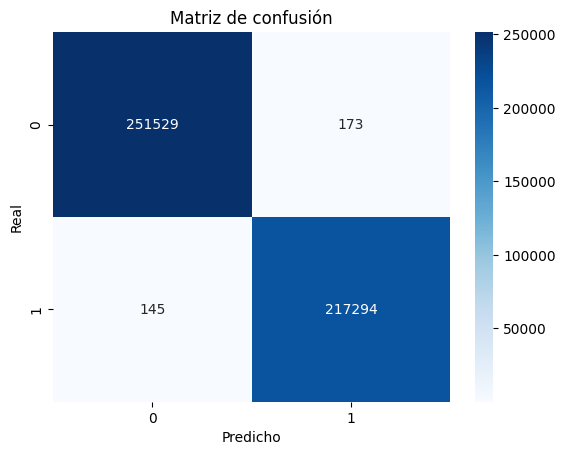

In [131]:
loss, accuracy = classifier.evaluate(X_test, y_test, verbose=0)

print(f"\nPrecisión en test: {accuracy*100:.2f}%")

# Métricas detalladas

y_pred = (classifier.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de confusión')

plt.xlabel('Predicho')

plt.ylabel('Real')

plt.show()

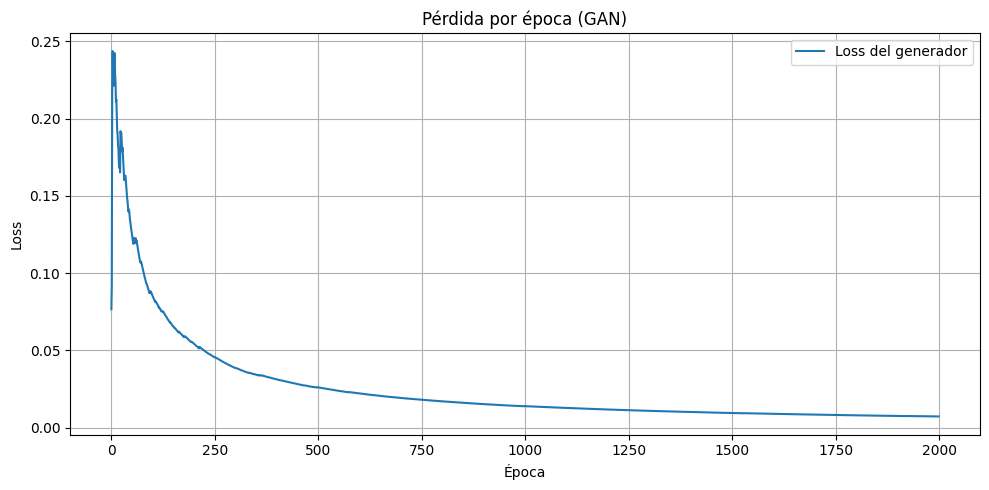

In [134]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss del generador')
plt.title('Pérdida por época (GAN)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Save the model

In [132]:
classifier.save("modelo_principal.keras")

We also save X_filtered because we will need it to compare the GAN results

In [ ]:
X_filtered = X_filtered.reset_index(drop=True)
y = y.reset_index(drop=True)

X_filtered["Target"] = y

In [145]:
X_filtered.to_csv("X_filtered.csv", index=False)